# <span style='background:Yellow'> Bottom Temp & Salt difference between SODA and WOA

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas
import scipy
import xesmf as xe

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
woa_path = '/home/jovyan/chapter1/WOA/'
soda_path = '/home/jovyan/chapter1/SODA/'
woa0512_pt = xr.open_dataset(woa_path+'pt_bottom_wg_0512.nc', decode_times=False)
woa0512_pt_error = xr.open_dataset(woa_path+'pt_bottom_error_0512.nc', decode_times=False)
woa0512_slt = xr.open_dataset(woa_path+'san_bottom_wg_0512.nc', decode_times=False)
woa0512_slt_error = xr.open_dataset(woa_path+'san_bottom_error_0512.nc', decode_times=False)

soda_temp = xr.open_dataset(soda_path+'bottom_temp.nc')
soda_std_temp = xr.open_dataset(soda_path+'bottom_temp_std.nc')
soda_slt = xr.open_dataset(soda_path+'bottom_salt.nc')
soda_std_slt = xr.open_dataset(soda_path+'bottom_salt_std.nc')

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcsfs_w_token = gcsfs.GCSFileSystem(token=token)

land_mask = xr.open_dataarray('hfacc.nc')
depth = xr.open_dataarray('depth.nc')

In [10]:
swap = land_mask.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})
land_mask = swap.assign_coords({"lon": swap.xt_ocean, 'lat':swap.yt_ocean}).drop(['xt_ocean', 'yt_ocean'])

# <span style='background:Pink'> <font color='Red'> Temperature </font>

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp data onto SODA's grid

In [4]:
regridder = xe.Regridder(woa0512_pt.PT.drop('time'), soda_temp.temp.drop('time'), method='bilinear')

woa0512_pt_new_grid = regridder(woa0512_pt)
woa0512_pt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, lat: 208, lon: 381)
Coordinates:
  * time     (time) float32 6.0
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -57.49 -57.36 -57.23
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
Data variables:
    PT       (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.5279 0.5352 0.5418
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp error data onto SODA's grid

In [5]:
regridder_0512_error = xe.Regridder(woa0512_pt_error.drop('time'), soda_temp.drop('time'), method='bilinear')

woa0512_pt_error_new_grid = regridder(woa0512_pt_error)
woa0512_pt_error_new_grid

<xarray.Dataset>
Dimensions:   (time: 1, lat: 208, lon: 381)
Coordinates:
  * time      (time) float32 6.0
  * lat       (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -57.49 -57.36 -57.23
  * lon       (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
Data variables:
    PT_error  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.3611 0.3757 0.3721
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `SODA - WOA` (1981-2010) </font>

In [6]:
#checking if nans
print(np.isnan(soda_temp.temp.sum()))

<xarray.DataArray 'temp' ()>
array(False)
Coordinates:
    time     object ...


In [7]:
soda_woa0512_diff = soda_temp.temp - woa0512_pt_new_grid.isel(time=0).PT
soda_woa0512_diff

<xarray.DataArray (lat: 208, lon: 381)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.69425505,  0.65831327,  0.63571221, ..., -0.93416475,
        -0.94016409, -0.94555221],
       [ 0.67399067,  0.65031475,  0.63123363, ..., -0.97489529,
        -0.98158709, -0.98779455],
       [ 0.67646587,  0.64893436,  0.63617051, ..., -1.01448831,
        -1.02250076, -1.02986456]])
Coordinates:
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -57.49 -57.36 -57.23

In [8]:
lat = soda_woa0512_diff.lat
lon = soda_woa0512_diff.lon

Text(0.5, 1.0, 'Difference between \n SODA and WOA (2005-2012)')

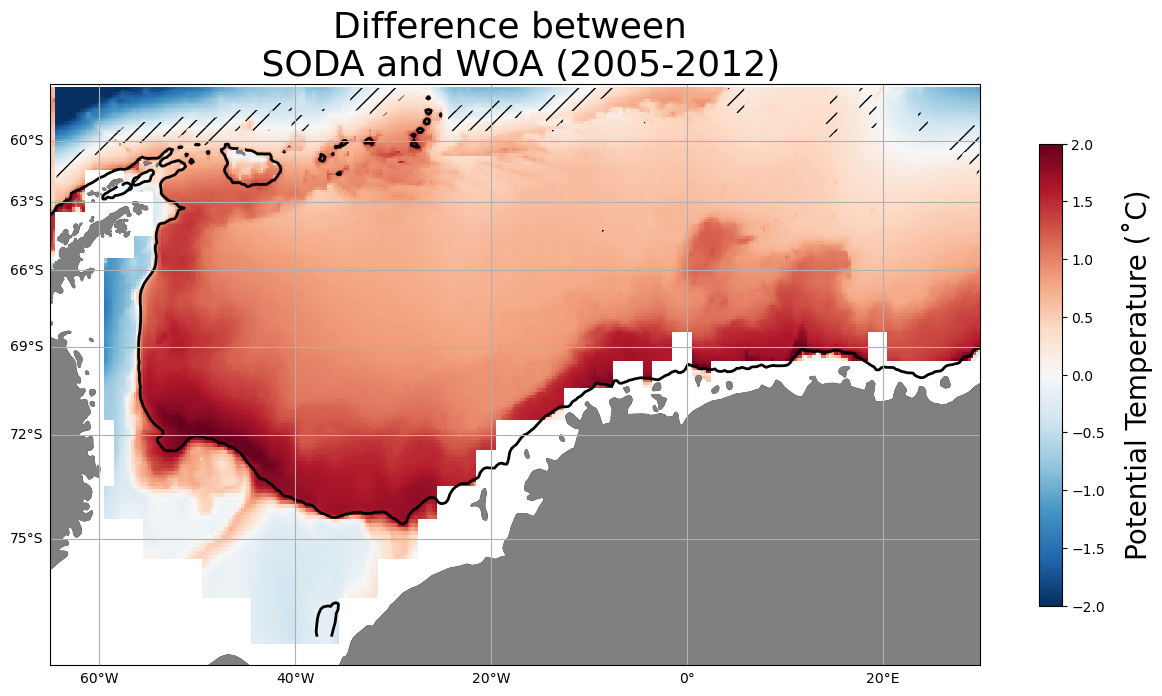

In [13]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(soda_woa0512_diff.lon, 
                   soda_woa0512_diff.lat, 
                   soda_woa0512_diff.where(land_mask), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

plt.contourf(soda_woa0512_diff.lon, 
             soda_woa0512_diff.lat,  
             soda_woa0512_diff.where(np.abs(soda_woa0512_diff) < woa0512_pt_error_new_grid.PT_error[0]).where(land_mask),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title("Difference between \n SODA and WOA (2005-2012)", fontsize=26)
#plt.savefig('bot-temp-sodaWoa0512-1kmisobath.pdf');

# <span style='background:Pink'> <font color='Red'> Salinity </font>

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt data onto SODA's grid

In [14]:
regridder_slt = xe.Regridder(woa0512_slt.drop('time'), soda_slt.drop('time'), method='bilinear')

woa0512_slt_new_grid = regridder_slt(woa0512_slt)
woa0512_slt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, lat: 208, lon: 381)
Coordinates:
  * time     (time) float32 6.0
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -57.49 -57.36 -57.23
Data variables:
    s_an     (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt ERROR data onto SODA's grid

In [15]:
regridder_slt_error = xe.Regridder(woa0512_slt_error.s_se.fillna(0.).drop('time'), soda_slt.drop('time'), method='bilinear')

woa0512_slt_error_new_grid = regridder_slt_error(woa0512_slt_error)
woa0512_slt_error_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, lat: 208, lon: 381)
Coordinates:
  * time     (time) float32 6.0
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -57.49 -57.36 -57.23
Data variables:
    s_se     (time, lat, lon) float32 0.0 0.0 0.0 ... 0.002368 0.002311 0.001947
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `SODA - WOA` (1981-2010) </font>

In [16]:
#checking if nans
print(np.isnan(soda_slt.sum()))

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     object ...
Data variables:
    salt     bool False


In [17]:
soda_woa0512_slt_diff = soda_slt.salt - woa0512_slt_new_grid.isel(time=0).s_an
soda_woa0512_slt_diff

<xarray.DataArray (lat: 208, lon: 381)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [3.4717407e+01, 3.4717407e+01, 3.4717392e+01, ..., 2.1717072e-02,
        2.1656036e-02, 2.1644592e-02],
       [3.4717354e+01, 3.4717373e+01, 3.4717403e+01, ..., 2.1598816e-02,
        2.1675110e-02, 2.1686554e-02],
       [3.4717381e+01, 3.4717373e+01, 3.4717384e+01, ..., 2.1575928e-02,
        2.1732330e-02, 2.1728516e-02]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -57.49 -57.36 -57.23

Text(0.5, 1.0, 'Difference between \n SODA and WOA (2005-2012)')

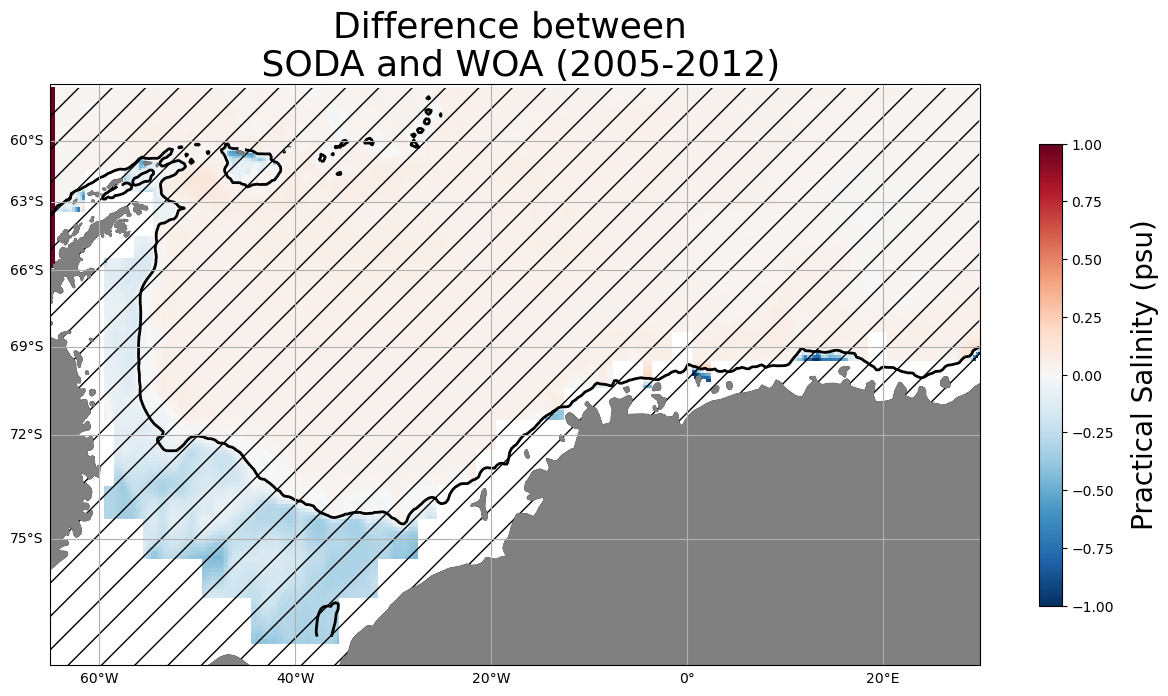

In [18]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(soda_woa0512_slt_diff.lon, 
                   soda_woa0512_slt_diff.lat, 
                   soda_woa0512_slt_diff.where(land_mask), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity (psu)", labelpad=12, fontsize=20)

plt.contourf(soda_woa0512_slt_diff.lon, 
             soda_woa0512_slt_diff.lat, 
             soda_woa0512_slt_diff.where(np.abs(soda_woa0512_slt_diff) < woa0512_slt_error_new_grid.s_se[0]).where(land_mask).fillna(0.),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title("Difference between \n SODA and WOA (2005-2012)", fontsize=26)
#plt.savefig('bot-salt-sodaWoa0512-1kmisobath.pdf');